# Polscope with phase forward simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
mag         = 40                  # magnification
ps          = 6.5/mag             # effective pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 0.55                # objective NA
NA_illu     = 0.4                 # illumination NA (condenser)
NA_illu_in  = 0.4                 # illumination NA (phase contrast inner ring)
z_defocus   = (np.r_[:5]-2)*1.757 # a set of defocus plane
chi         = 0.03*2*np.pi           # swing of Polscope analyzer


### Sample creation

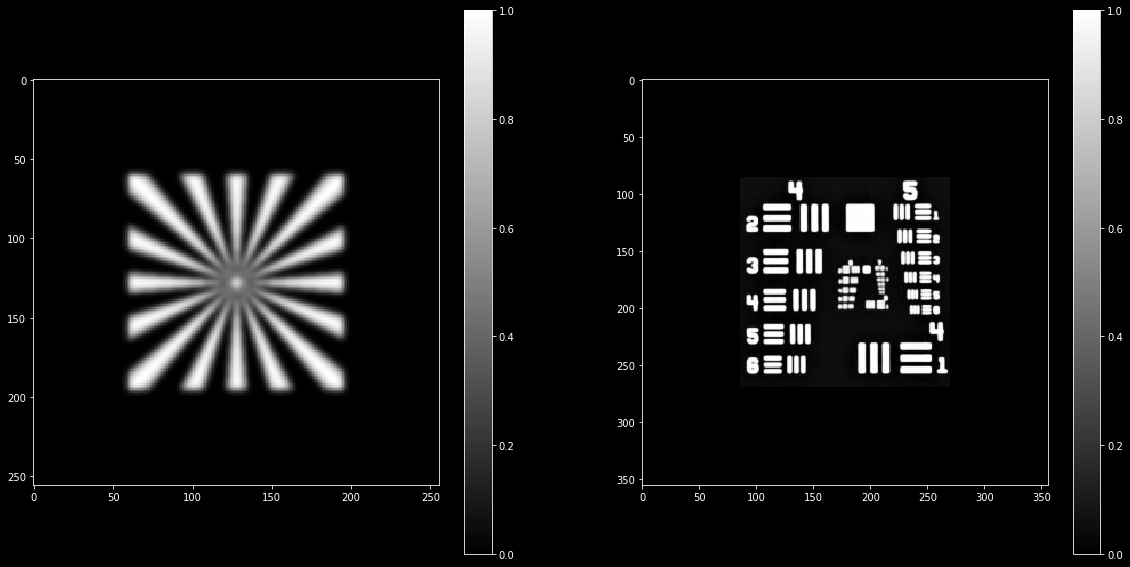

In [3]:

# generate Siemens star target

star, theta, _ = wo.genStarTarget(N,M)


# Load res_target
res_target = np.double(plt.imread('resolution.jpg'))
res_target = res_target[322:506,357:541,1]
res_target = np.pad(res_target/np.max(res_target),86,mode='constant')


wo.plot_multicolumn(np.array([star, res_target]), num_col=2, size=10)

In [4]:
0.3/2/np.pi*532

25.401128917466494

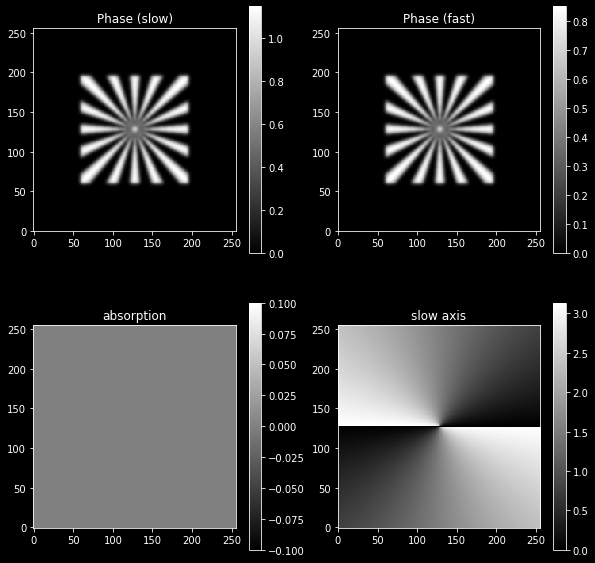

In [19]:
# Physical value assignment

phase_value = 1

phi_s = star*(phase_value + 0.15)
phi_f = star*(phase_value - 0.15)

# mu_s = res_target/5
mu_s = np.zeros((N,M))
mu_f = mu_s.copy()

t_eigen = np.zeros((2, N, M), complex)

t_eigen[0] = np.exp(-mu_s + 1j*phi_s)
t_eigen[1] = np.exp(-mu_f + 1j*phi_f)

sa = theta%np.pi

wo.plot_multicolumn(np.array([phi_s, phi_f, mu_s, sa]), \
                     num_col=2, size=5, set_title=True, \
                     titles=['Phase (slow)', 'Phase (fast)', 'absorption', 'slow axis'], origin='lower')



### Partially coherent forward model

In [6]:
# Subsampled Source pattern

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Source_cont = wo.gen_Pupil(fxx, fyy, NA_illu, lambda_illu)


Source_discrete = wo.Source_subsample(Source_cont, lambda_illu*fxx, lambda_illu*fyy, subsampled_NA = 0.1)

In [7]:
np.sum(Source_discrete)

55.0

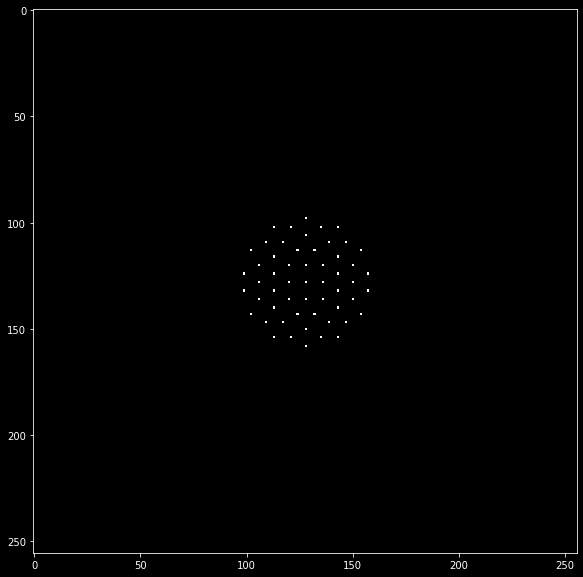

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(Source_discrete),cmap='gray')


In [9]:
# Microscope object generation

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                              illu_mode='Arbitrary', Source=Source_discrete)


setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                cali=False, bg_option='global', illu_mode='Arbitrary',Source=Source_discrete)


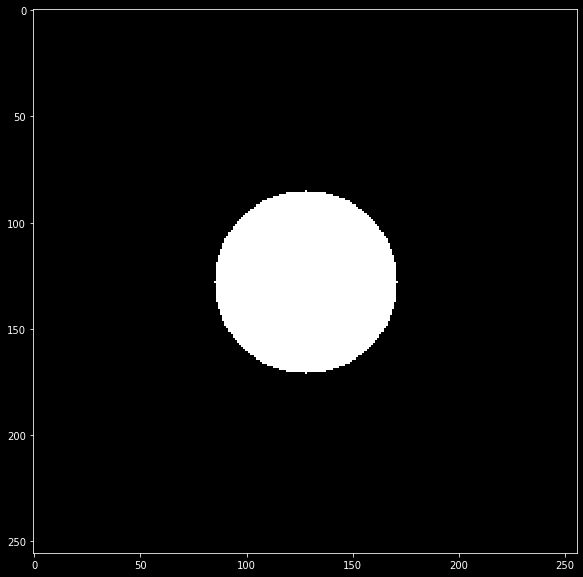

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(fftshift(setup.Pupil_obj)),cmap='gray')

In [11]:
wo.image_stack_viewer(np.real(np.transpose(setup.Hp,(2,0,1))))

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [12]:
I_meas, Stokes_out = simulator.simulate_waveorder_measurements(t_eigen, sa, multiprocess=False)

Number of sources considered (55 / 55) in pattern (1 / 1), elapsed time: 9.88


In [20]:
wo.parallel_4D_viewer(np.transpose(Stokes_out,(3,0,1,2)), num_col=2, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [21]:
wo.image_stack_viewer(np.transpose(Stokes_out[0]+Stokes_out[3], (2,0,1)), origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [15]:
t_eigen.shape

(2, 256, 256)

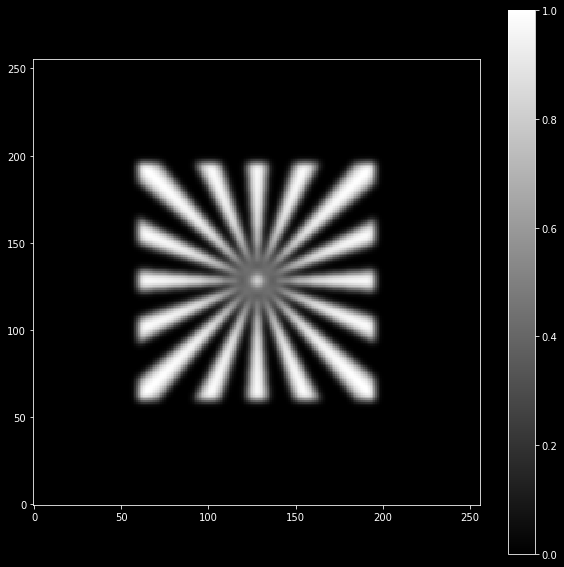

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(np.angle(np.sum(t_eigen,axis=0)), cmap='gray', origin='lower')
plt.colorbar()

In [17]:
# Add noise to the measurement

photon_count = 14000
ext_ratio    = 10000
const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio

I_meas_noise = (np.random.poisson(I_meas/np.max(I_meas) * photon_count + const_bg)).astype('float64')


In [23]:
wo.parallel_4D_viewer(np.transpose(I_meas_noise,(3,0,1,2)), num_col=2, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [21]:
# Save simulations

f = open('simulation_data_phase_1_noise_256.pckl', 'wb')
pickle.dump((I_meas_noise, Stokes_out, lambda_illu, ps, NA_obj, NA_illu, Source_discrete, z_defocus, chi), f)
f.close()